In [1]:
import sys
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

sys.path.append('..')
sys.path.append('../classes/')
sys.path.append('../data/')
sys.path.append('../model_weights/')

from utilities import *
from classes.ClockDataset import *
from classes.CommonSenseError import *
from classes.Models import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


<h4>Load data and labels</h4>

data: torch.Size([18000, 1, 150, 150]), labels: torch.Size([18000, 6])


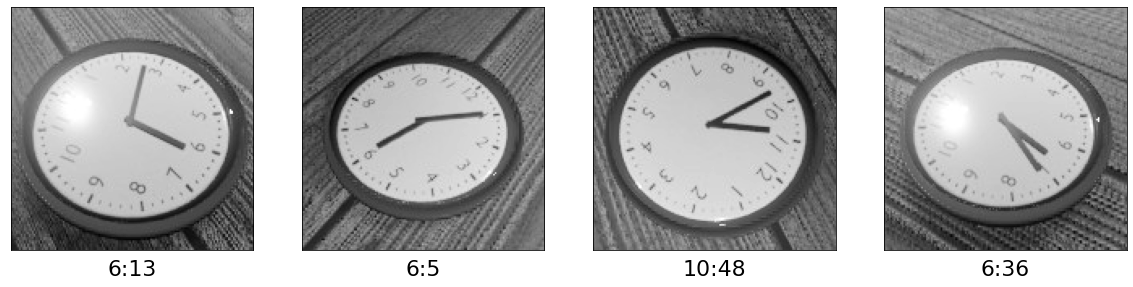

In [10]:
# Load data and add sine and cosine transform to labels
data, labels = load_data('../data')
labels = transform_labels(labels)
print(f"data: {data.shape}, labels: {labels.shape}")

# Choose image samples
samples = []
sample_labels = []
for i in range(4):
    label = i+2550
    sample_labels.append(str(int(labels[label][0].item()))+":"+str(int(labels[label][1].item())))
    img_arr = (data[label].numpy().squeeze(axis=0)*255).astype(np.uint8)
    samples.append(img_arr)

# Plot image samples
font = {'size': 22}
plt.rc('font', **font)
fig, axis = plt.subplots(1,4, figsize=(20,12))
for i in range(4):
    axis[i].imshow(samples[i], cmap="gray")
    axis[i].set_xlabel(sample_labels[i], labelpad=10)
for ax in axis:
    ax.set_xticks([])
    ax.set_yticks([])

<br/>
<h3>Dataset creation</h3>

In [3]:
# Create main dataset
clock_dataset = ClockDataset(data, labels)
train_data, test_data, val_data = random_split(clock_dataset, [16000,1000,1000])

# Split dataset into train, test and validation sets
train_data_loader = DataLoader(train_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)
val_data_loader = DataLoader(val_data, batch_size=64)

# Prepare target array to use for evaluation as 1 big batch
targets = []
for i in range(len(test_data)):
    targets.append(test_data[i][1])
targets = np.vstack(targets)

# print shapes of batches (channels first)
for X, y in train_data:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 150, 150])
Shape of y: torch.Size([6]) torch.float32


<br/>
<h3>Model creation</h3>

In [4]:
model = NN_regression(input_channels=1,h=150,w=150, n_outputs=4).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

<h4>Main model training step</h4>

In [5]:
epochs = 150
patience = 10
weights_name = 'temp_weights'
approach = "periodic_labels"
# Main training loop
curr_patience = 0
train_losses = []
eval_losses = []
mean_test_loss = np.inf
print("\n~~~Starting training~~~\n")
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Training step
    train_l = train(train_data_loader, model, loss, 
                    optimizer, device, approach)
    train_mean = torch.mean(train_l)
    train_losses.append(train_mean)
    print(f"Train loss: {train_mean:>7f}")

    # Evaluation step
    eval_l = evaluate(val_data_loader, model, loss, device, approach)
    eval_mean = torch.mean(eval_l)
    eval_losses.append(eval_mean)
    print(f"Test avg loss: {eval_mean:>8f}")

    # Save new weights if they are better
    if (weights_name != None) and (eval_mean < mean_test_loss):
        print("Found new best weights.")
        mean_test_loss = eval_mean
        torch.save(model.state_dict(), "../model_weights/"+weights_name)
        curr_patience = 0
    print()

    # Stop training if patience expired
    if curr_patience >= patience:
        print(f"No new best weights found after {patience} iterations.")
        break
    curr_patience += 1

end_time = time.time()
print(f"Training finished in {np.round(end_time-start_time, 3)} seconds.")


~~~Starting training~~~

Epoch 1
-------------------------------
Train loss: 0.413883
Test avg loss: 0.306784
Found new best weights.

Epoch 2
-------------------------------
Train loss: 0.293981
Test avg loss: 0.247794
Found new best weights.

Epoch 3
-------------------------------
Train loss: 0.240232
Test avg loss: 0.189270
Found new best weights.

Epoch 4
-------------------------------
Train loss: 0.193327
Test avg loss: 0.147586
Found new best weights.

Epoch 5
-------------------------------
Train loss: 0.153925
Test avg loss: 0.118908
Found new best weights.

Epoch 6
-------------------------------
Train loss: 0.125664
Test avg loss: 0.097400
Found new best weights.

Epoch 7
-------------------------------
Train loss: 0.105302
Test avg loss: 0.082787
Found new best weights.

Epoch 8
-------------------------------
Train loss: 0.090175
Test avg loss: 0.073064
Found new best weights.

Epoch 9
-------------------------------
Train loss: 0.078308
Test avg loss: 0.062362
Found new

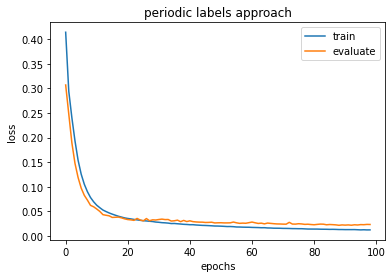

In [6]:
# Plot losses
train_losses = np.vstack(train_losses)
test_losses = np.vstack(eval_losses)

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="evaluate")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("periodic labels approach")
plt.show()

<h4>Test our model with the unseen data in the test data set</h4>

In [7]:
# make predictions
predictions = predict(test_data_loader, model, loss, device, approach)

# transform cosine and sine back to integer values
true_preds = denormalize_time(predictions)

# calculate and print common sense error
cse = CommonSenseError()
cse_error = cse(torch.FloatTensor(true_preds),torch.FloatTensor(targets[:,:2]))

print(f"Common sense error on test dataset: {np.round(cse_error.numpy(),3)}")

Avg evaluation loss: 0.024294 

Common sense error on test dataset: 15.295999526977539
